In [1]:
import pandas as pd

real = pd.read_csv('../spam_text_data/real_message_vector.csv')
test = pd.read_csv('../spam_text_data/bg_message_vector.csv')

In [2]:
print(real.shape)
print(test.shape)

(200, 1164)
(200, 1164)


In [3]:
real_arr = real.to_numpy()
test_arr = test.to_numpy()

In [4]:
import numpy as np

class CPCA:
    def __init__(self, alpha=1, n_components=2):
        self.n_components = n_components
        self.alpha = alpha
        self.topEigenVector = None  # Store principal components

    def fit_transform(self, foreground, background):
        if foreground.shape[1] != background.shape[1]:
            raise ValueError('Foreground and background datasets must have the same number of features (columns)')

        # Compute covariance matrices (corrected version)
        fg_cov = np.cov(foreground, rowvar=False)  # Covariance of foreground
        bg_cov = np.cov(background, rowvar=False)  # Covariance of background

        # Compute contrastive covariance matrix
        sigma = fg_cov - self.alpha * bg_cov

        # Eigen decomposition
        eigenValues, eigenVectors = np.linalg.eigh(sigma)  # More stable for symmetric matrices

        # Sort eigenvectors by eigenvalues in descending order
        top_indices = np.argsort(-eigenValues.real)[:self.n_components]
        self.topEigenVector = eigenVectors.real[:, top_indices]  # Store for later use

        # Projected data
        projected_data = foreground @ self.topEigenVector

        return projected_data

    def transform(self, new_data):
        if self.topEigenVector is None:
            raise ValueError("Model has not been fitted. Call fit_transform first.")

        return new_data @ self.topEigenVector  # Project new data using learned components

In [5]:
bg_text = pd.read_csv('../spam_text_data/combo_message.csv')

In [6]:
bg_text["scam_flag"].unique()

array([0, 1])

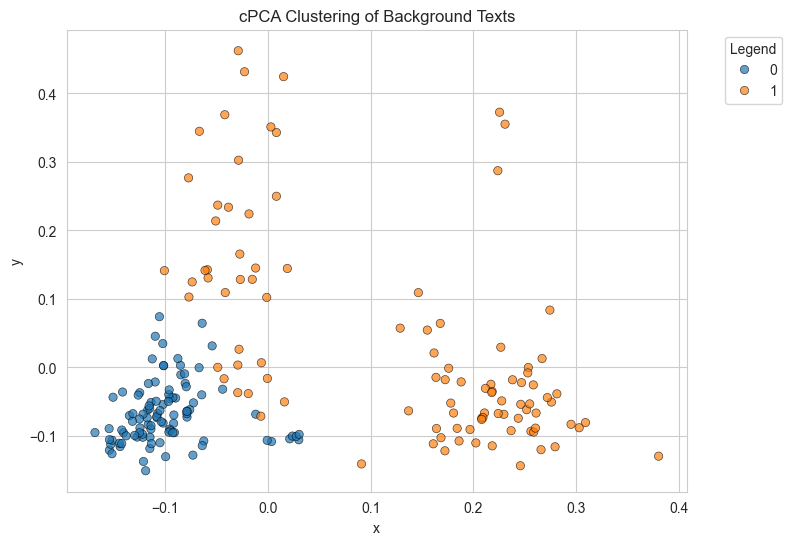

In [7]:
import matplotlib.pyplot as plt


cpca = CPCA(alpha=1)
transformed_data = cpca.fit_transform(test_arr, real_arr)




import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'x': transformed_data[:, 0],
    'y': transformed_data[:, 1],
    'label': bg_text["scam_flag"]
})

sns.set_style("whitegrid")

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(
    data=df, x='x', y='y', hue='label', palette='tab10', alpha=0.7, edgecolor="black"
)

plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('cPCA Clustering of Background Texts')
plt.show()


In [8]:
test1 = pd.read_csv('../spam_text_data/test_message_vector.csv')
test1.head()

,00,000,10,11,110,112679,114998,12,120,123,...,www,xyz,year,yes,you,your,yours,zelle,zen,zpass
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.408541,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.109489,0.0,0.0,0.0,0.0
1,0.0,0.0,0.253844,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.259553,0.0,0.453305,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.076804,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [9]:
import time

test1_arr = test1.to_numpy()

start_time = time.time()
new_projection = cpca.transform(test1_arr)
end_time = time.time()

transform_time = end_time - start_time

In [10]:
test1_text = pd.read_csv('../spam_text_data/test_all.csv')

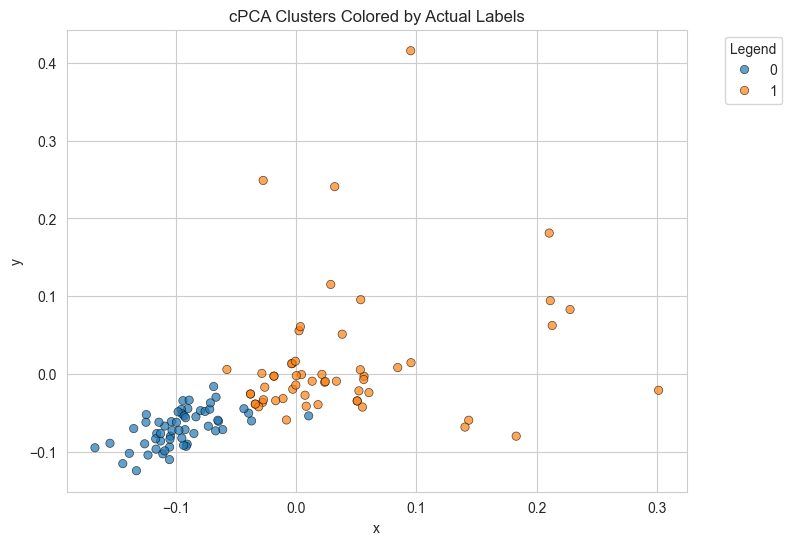

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'x': new_projection[:, 0],
    'y': new_projection[:, 1],
    'label': test1_text["scam_flag"]
})

sns.set_style("whitegrid")

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(
    data=df, x='x', y='y', hue='label', palette='tab10', alpha=0.7, edgecolor="black"
)

plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('cPCA Clusters Colored by Actual Labels')
plt.show()

In [12]:
from sklearn.cluster import KMeans

n_clusters = 2

start_time = time.time()
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(new_projection)
end_time = time.time()

kmeans_time = end_time - start_time

In [13]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix


def match_cluster_labels(true_labels, kmeans_labels):
    """
    matching cluster labels to achieve comparable cluster assignments.
    """
    conf_matrix = confusion_matrix(true_labels, kmeans_labels)

    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    label_mapping = {old: new for old, new in zip(col_ind, row_ind)}

    new_kmeans_labels = np.array([label_mapping[label] for label in kmeans_labels])

    return new_kmeans_labels

# Usage
corrected_labels = match_cluster_labels(test1_text["scam_flag"], labels)


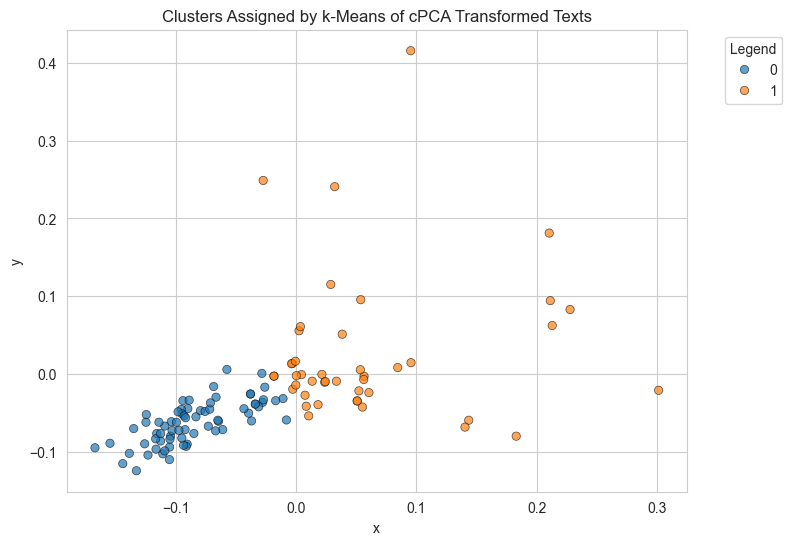

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'x': new_projection[:, 0],
    'y': new_projection[:, 1],
    'label': corrected_labels
})

sns.set_style("whitegrid")

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(
    data=df, x='x', y='y', hue='label', palette='tab10', alpha=0.7, edgecolor="black"
)

plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Clusters Assigned by k-Means of cPCA Transformed Texts')
plt.show()

In [15]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

nmi = normalized_mutual_info_score(test1_text["scam_flag"], corrected_labels)
print(f"Normalized Mutual Information: {nmi}")
ari = adjusted_rand_score(test1_text["scam_flag"], corrected_labels)
print(f"Adjusted Rand Index: {ari}")
silhouette_score = silhouette_score(new_projection, corrected_labels)
print(f"Silhouette Score: {silhouette_score}")

Normalized Mutual Information: 0.5220276761880193
Adjusted Rand Index: 0.5621036738802214
Silhouette Score: 0.49815487713842577


In [16]:
print("Total Time:", kmeans_time + transform_time, " seconds")

Total Time: 0.016196012496948242  seconds
